In [1]:
import numpy as np
import pandas as pd 

import os
        
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib

import splitfolders 
import glob
import plotly.express as px


<h1>setting path</h1>

In [2]:
data_dir = "Pistachio_Image_Dataset/Pistachio_Image_Dataset/"
data_dir =pathlib.Path(data_dir)

In [26]:
Total_Images = glob.glob('Pistachio_Image_Dataset/Pistachio_Image_Dataset/*/*.jpg')
print("Total number of images: ", len(Total_Images))

Total_Images = pd.Series(Total_Images)

Total number of images:  2148


In [3]:
train_path='./output/train/'
val_path='./output/val'
test_path='./output/test'
class_names=os.listdir(train_path)
class_names_val=os.listdir(val_path)
class_names_test=os.listdir(test_path)

<h1> EfficientNet</h1>

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define data transforms
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)
val_dataset = datasets.ImageFolder(root=val_path, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained EfficientNet model
model = models.efficientnet_b0(pretrained=True)

# Modify the model for binary classification
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    # nn.Dropout(0.5),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)

# Set layers to be trainable
for param in model.parameters():
    param.requires_grad = False

# Only fine-tune the last few layers
for param in model.classifier.parameters():
    param.requires_grad = True

# Check which layers are trainable
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")


D:\anaconda3\envs\pytorch_py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\pytorch_py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features.0.0.weight: False
features.0.1.weight: False
features.0.1.bias: False
features.1.0.block.0.0.weight: False
features.1.0.block.0.1.weight: False
features.1.0.block.0.1.bias: False
features.1.0.block.1.fc1.weight: False
features.1.0.block.1.fc1.bias: False
features.1.0.block.1.fc2.weight: False
features.1.0.block.1.fc2.bias: False
features.1.0.block.2.0.weight: False
features.1.0.block.2.1.weight: False
features.1.0.block.2.1.bias: False
features.2.0.block.0.0.weight: False
features.2.0.block.0.1.weight: False
features.2.0.block.0.1.bias: False
features.2.0.block.1.0.weight: False
features.2.0.block.1.1.weight: False
features.2.0.block.1.1.bias: False
features.2.0.block.2.fc1.weight: False
features.2.0.block.2.fc1.bias: False
features.2.0.block.2.fc2.weight: False
features.2.0.block.2.fc2.bias: False
features.2.0.block.3.0.weight: False
features.2.0.block.3.1.weight: False
features.2.0.block.3.1.bias: False
features.2.1.block.0.0.weight: False
features.2.1.block.0.1.weight: Fals

In [6]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

numEpochs = 30

<h1>Training</h1>

In [7]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=numEpochs):
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs.squeeze() > 0.5).long()
            corrects += torch.sum(preds == labels)
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                
                val_loss += loss.item() * inputs.size(0)
                preds = (outputs.squeeze() > 0.5).long()
                val_corrects += torch.sum(preds == labels)
                val_total += labels.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        
        print(f"Validation Loss: {val_loss:.4f} Validation Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'EfficientNet_best_model_pretrained.pth')

    
train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 0/29
Loss: 0.5233 Acc: 0.7967
Validation Loss: 0.3915 Validation Acc: 0.8972
Epoch 1/29
Loss: 0.3739 Acc: 0.8777
Validation Loss: 0.3265 Validation Acc: 0.8832
Epoch 2/29
Loss: 0.3053 Acc: 0.9033
Validation Loss: 0.2852 Validation Acc: 0.9019
Epoch 3/29
Loss: 0.2696 Acc: 0.9144
Validation Loss: 0.2551 Validation Acc: 0.8925
Epoch 4/29
Loss: 0.2516 Acc: 0.9185
Validation Loss: 0.2247 Validation Acc: 0.9206
Epoch 5/29
Loss: 0.2359 Acc: 0.9208
Validation Loss: 0.2245 Validation Acc: 0.9112
Epoch 6/29
Loss: 0.2344 Acc: 0.9121
Validation Loss: 0.2190 Validation Acc: 0.9019
Epoch 7/29
Loss: 0.2125 Acc: 0.9272
Validation Loss: 0.2150 Validation Acc: 0.9065
Epoch 8/29
Loss: 0.2109 Acc: 0.9284
Validation Loss: 0.2034 Validation Acc: 0.9065
Epoch 9/29
Loss: 0.2058 Acc: 0.9272
Validation Loss: 0.1877 Validation Acc: 0.9206
Epoch 10/29
Loss: 0.2096 Acc: 0.9196
Validation Loss: 0.1927 Validation Acc: 0.9065
Epoch 11/29
Loss: 0.2018 Acc: 0.9284
Validation Loss: 0.1915 Validation Acc: 0.9065
Ep

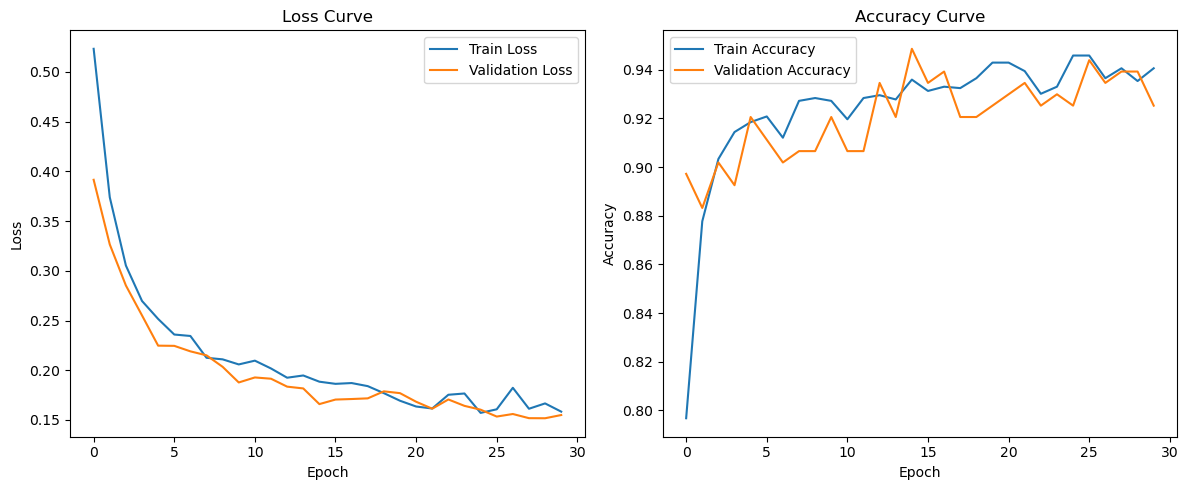

In [8]:
# Plotting the curves
epochs_range = range(numEpochs)
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# save
plt.savefig('EfficientNet_train.png', dpi=600, bbox_inches='tight')

plt.tight_layout()
plt.show()


<h1>Evaluation</h1>

In [9]:
import pandas as pd
import os
from sklearn.metrics import classification_report
import numpy as np
import torch
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import confusion_matrix

# Load the best model
model.load_state_dict(torch.load('EfficientNet_best_model_pretrained.pth'))

# Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs.squeeze() > 0.5).long()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute and print confusion matrix
conf_matrix = confusion_matrix(np.array(y_true), np.array(y_pred))
print("Confusion Matrix:")
print(conf_matrix)

TP = conf_matrix[0, 0]
TN = conf_matrix[1, 1]
FP = conf_matrix[1, 0]
FN = conf_matrix[0, 1]

print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

accuracy = (TP + TN) / (TP + TN + FP + FN)
F1 = 2*TP/(2*TP + FP + FN)
sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy:.4f}")
print(f"F-1 Score: {F1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Specificity: {specificity:.4f}")

# Save results to DataFrame
filenames = [os.path.basename(x[0]) for x in test_loader.dataset.imgs]
class_indices = test_loader.dataset.class_to_idx
indices = {v: k for k, v in class_indices.items()}

val_df = pd.DataFrame({
    'filename': filenames,
    'actual': [indices[x] for x in y_true],
    'predicted': [indices[x] for x in y_pred]
})
val_df['Same'] = val_df['actual'] == val_df['predicted']
val_df = val_df.sample(frac=1).reset_index(drop=True)

print(val_df.head(10))


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18768\2731149808.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('EfficientNet_best

Confusion Matrix:
[[117   7]
 [  4  89]]
True Positives (TP): 117
True Negatives (TN): 89
False Positives (FP): 4
False Negatives (FN): 7
Accuracy: 0.9493
F-1 Score: 0.9551
Sensitivity: 0.9435
Precision: 0.9669
Specificity: 0.9570
          filename             actual          predicted  Same
0  kirmizi 751.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio  True
1  kirmizi 299.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio  True
2   siirt (15).jpg    Siirt_Pistachio    Siirt_Pistachio  True
3     siirt 63.jpg    Siirt_Pistachio    Siirt_Pistachio  True
4   siirt (18).jpg    Siirt_Pistachio    Siirt_Pistachio  True
5     siirt 44.jpg    Siirt_Pistachio    Siirt_Pistachio  True
6  kirmizi 766.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio  True
7    siirt 513.jpg    Siirt_Pistachio    Siirt_Pistachio  True
8    siirt 354.jpg    Siirt_Pistachio    Siirt_Pistachio  True
9    siirt 518.jpg    Siirt_Pistachio    Siirt_Pistachio  True


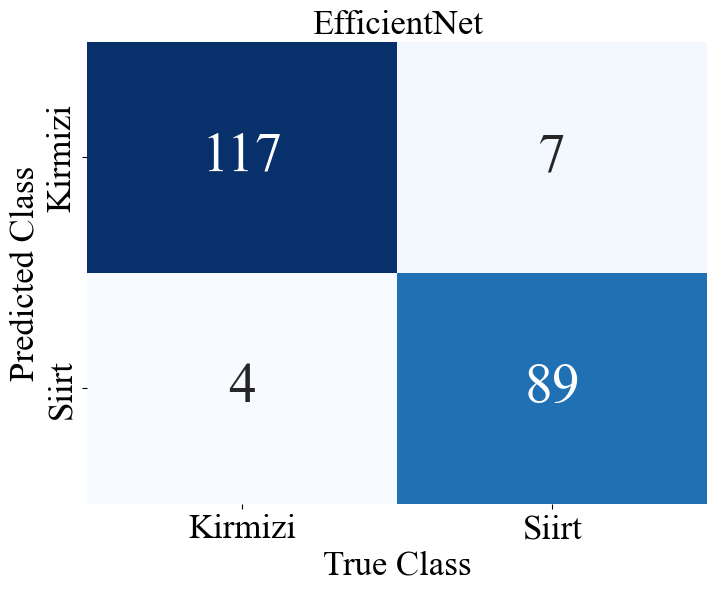

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# set font as Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# plot of confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Kirmizi', 'Siirt'],
            yticklabels=['Kirmizi', 'Siirt'],
            cbar=False, annot_kws={"size": 40})
plt.xlabel('True Class', fontsize=25)
plt.ylabel('Predicted Class', fontsize=25)
plt.title('EfficientNet', fontsize=25)

ax.tick_params(axis='both', labelsize=25)

# save
plt.savefig('EfficientNet_confusion_matrix.png', dpi=600, bbox_inches='tight')

plt.show()
